
RandomForest Performance:
  R^2 Score:           0.9356
  Mean Squared Error:  294.1366
  Mean Absolute Error: 11.8512
  PHM08 Score (sum):   1482860.0805
  PHM08 Score (avg):   359.3070

SVR Performance:
  R^2 Score:           0.6874
  Mean Squared Error:  1428.1674
  Mean Absolute Error: 26.0489
  PHM08 Score (sum):   3706892.2965
  PHM08 Score (avg):   898.2051

Ensemble Performance:
  R^2 Score:           0.8583
  Mean Squared Error:  647.3744
  Mean Absolute Error: 18.3484
  PHM08 Score (sum):   192992.3671
  PHM08 Score (avg):   46.7634


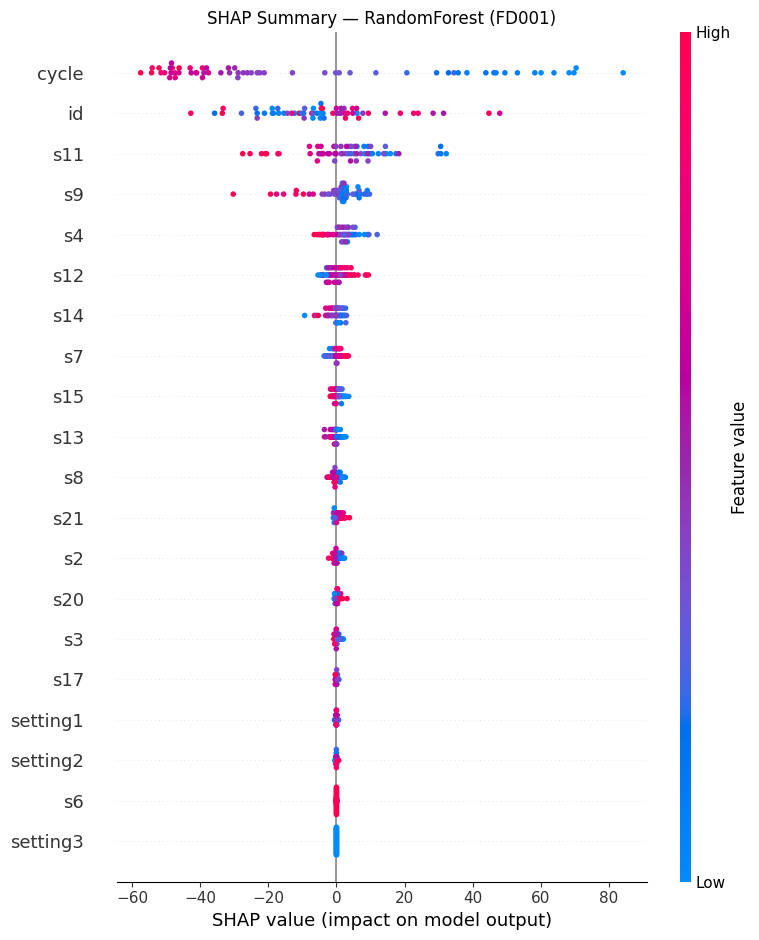

  0%|          | 0/60 [00:00<?, ?it/s]

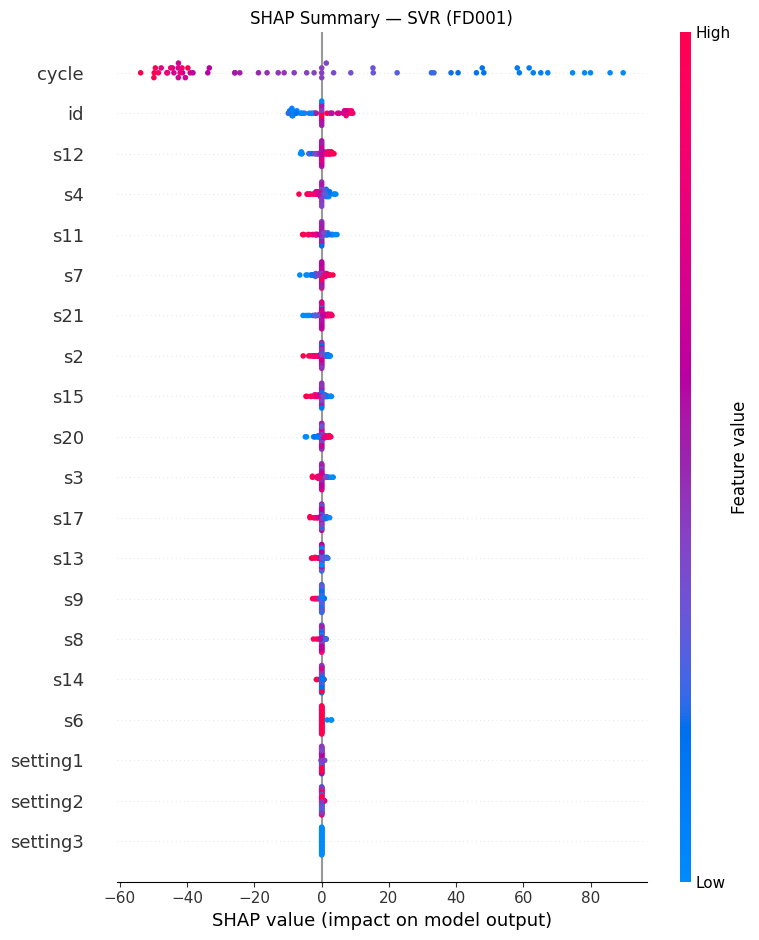

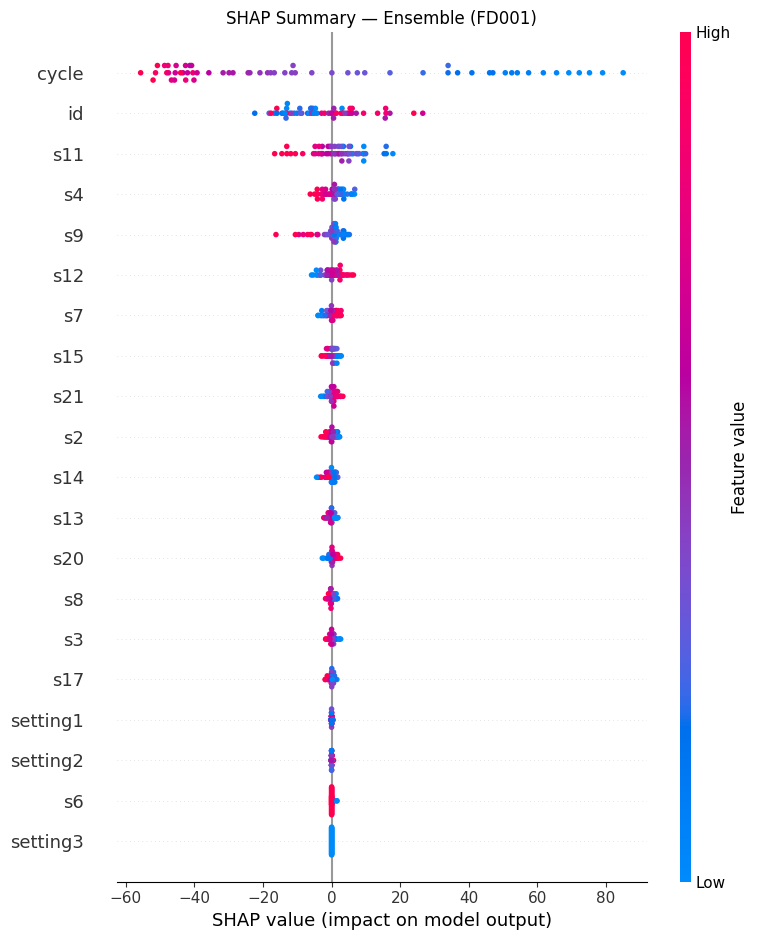

  0%|          | 0/1 [00:00<?, ?it/s]

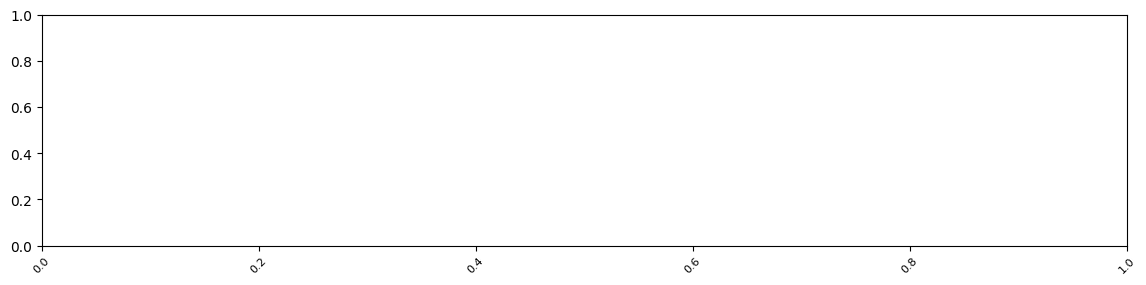

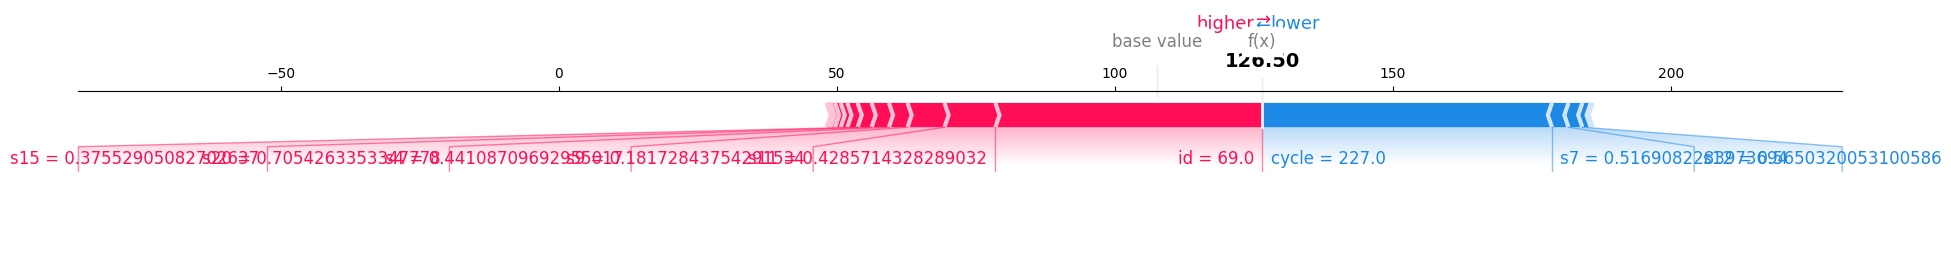

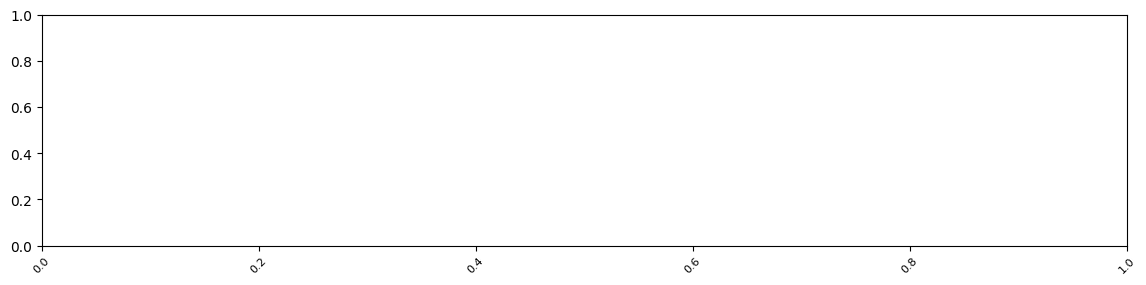

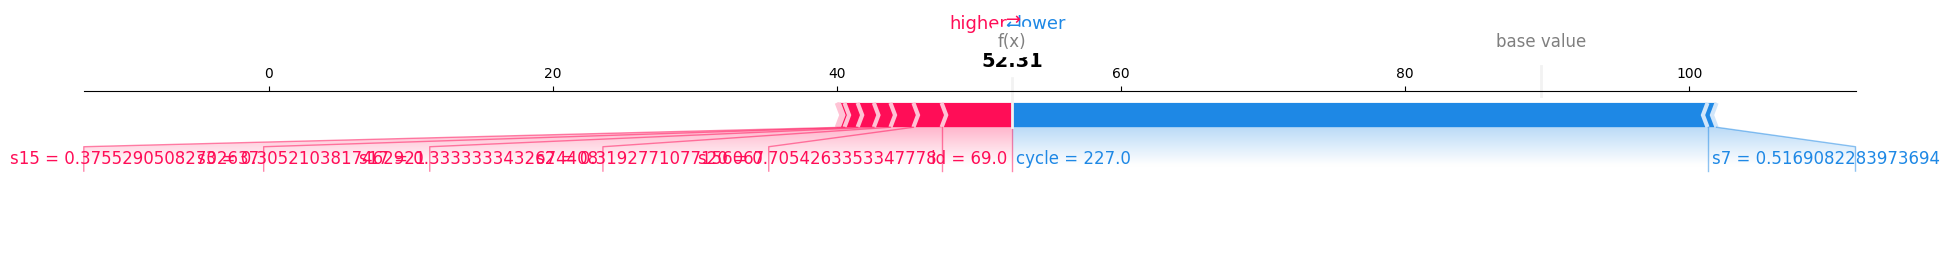

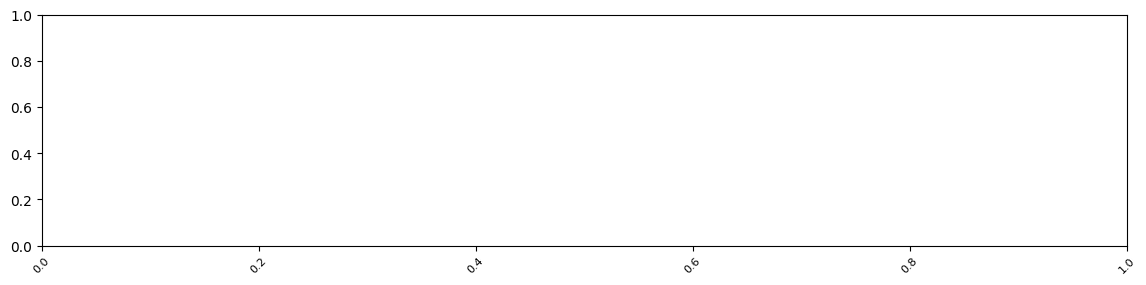

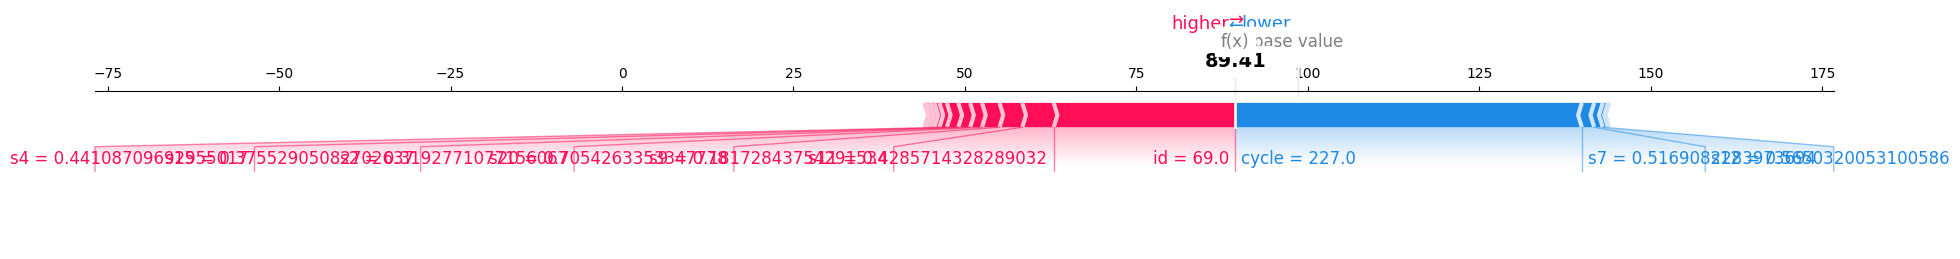

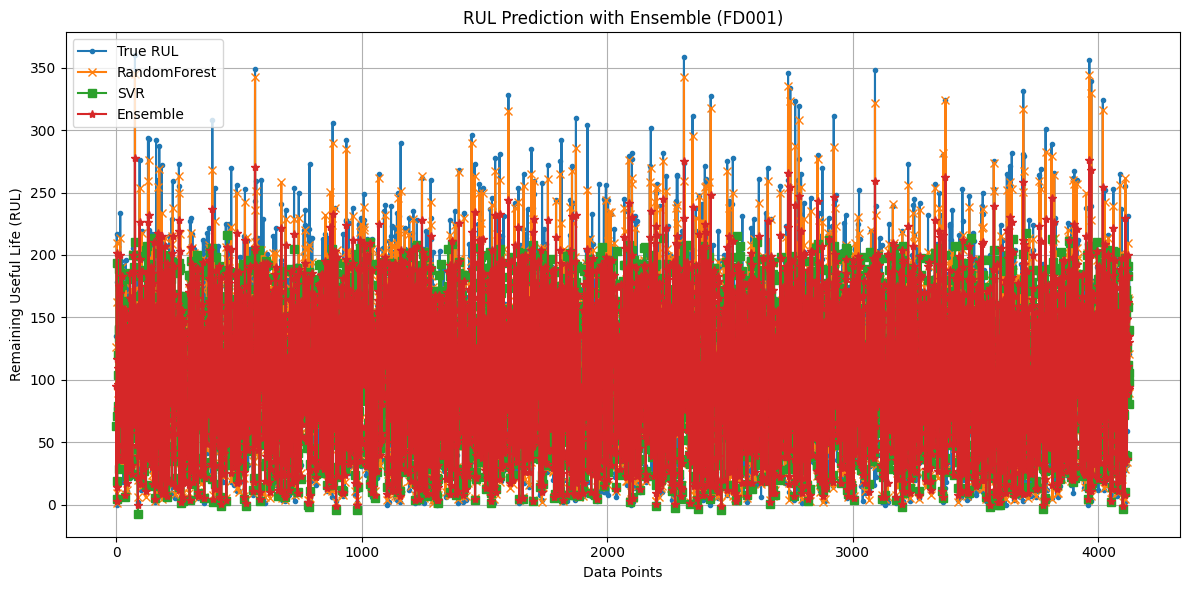



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (RandomForest) ---
Fold1: R2=0.4488, RMSE=52.5606, MAE=33.7359, PHM08_sum=2648626292.8798, PHM08_avg=642870.4594
Fold2: R2=0.5577, RMSE=46.0702, MAE=29.4625, PHM08_sum=102772815.2391, PHM08_avg=24866.3961
Fold3: R2=0.4828, RMSE=49.5838, MAE=31.5664, PHM08_sum=59071395.3049, PHM08_avg=14316.8675
Fold4: R2=0.5952, RMSE=43.2325, MAE=30.3178, PHM08_sum=7830895.0209, PHM08_avg=1898.3988
Fold5: R2=0.3379, RMSE=54.8225, MAE=35.9800, PHM08_sum=305822609930.2056, PHM08_avg=74102885.8566
Overall: R2=0.4850, RMSE=49.4317, MAE=32.2114, PHM08_sum=308640911328.6503, PHM08_avg=14960055.8058

--- GroupKFold (SVR) ---
Fold1: R2=0.6182, RMSE=43.7447, MAE=31.3085, PHM08_sum=14182468.6092, PHM08_avg=3442.3467
Fold2: R2=0.6929, RMSE=38.3891, MAE=24.6344, PHM08_sum=7129994.2

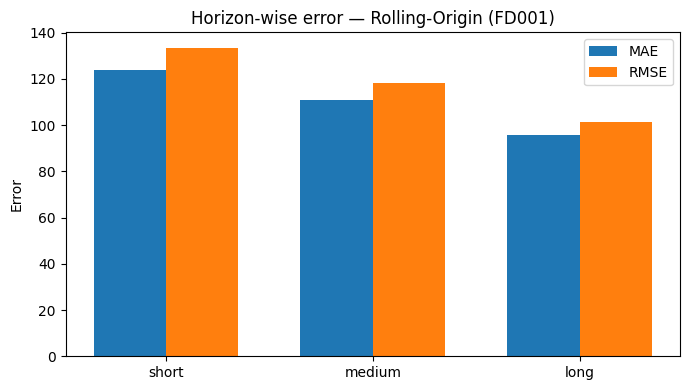

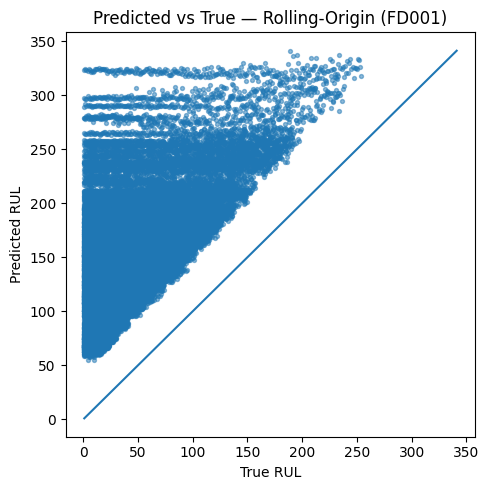


[PER-ENGINE MAE] (Top 10 worst engines)
69    167.213435
92    153.511017
96    151.898416
67    149.531281
83    139.524134
86    138.902354
64    136.178170
56    135.368259
95    135.161832
2     133.828085
dtype: float64


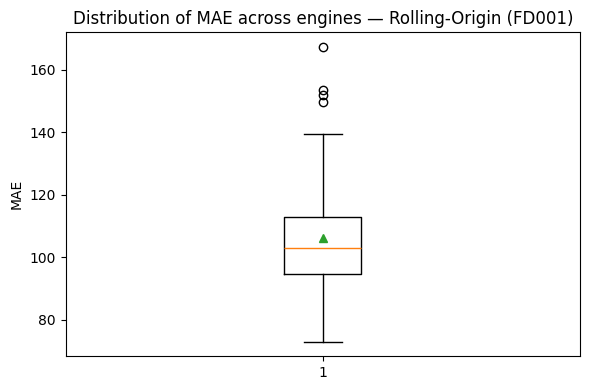

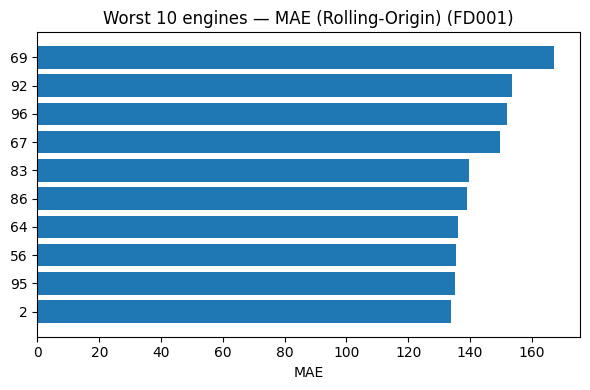


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.3139
    RMSE: 119.2427
     MAE: 110.9803
 sMAPE_%: 112.1094

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4851 ± 0.0911
Without id/cycle : R²=0.6193 ± 0.0488


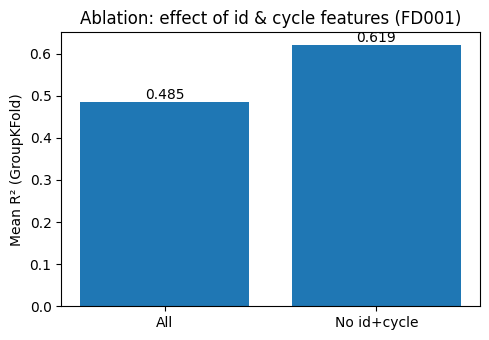


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 20631
Train (80%)   : 16504  → ratio=0.8000
Test  (20%)   : 4127  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1045.10 seconds
CPU% at start        : 18.7%   (~0.49 GHz)
CPU% at end          : 21.5%   (~0.56 GHz)
Memory at start      : 883.46 MB
Memory at end        : 1078.16 MB   (Δ 194.69 MB)


In [3]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD001"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "rfsvr"

# Fixed model hyperparameters (as requested)
RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    random_state=None,
    n_jobs=-1,
)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (RF + SVR)
# ============================================
rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_rf + 0.5 * y_svr

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_rf  = print_block_metrics("RandomForest", y_val, y_rf)
m_svr = print_block_metrics("SVR",          y_val, y_svr)
m_ens = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_rf, m_svr, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations
# RF: TreeExplainer; SVR: KernelExplainer 
# ============================================

X_tr32 = X_train.astype(np.float32)
X_val32 = X_val.astype(np.float32)

eval_size = min(60, X_val32.shape[0])
X_shap_small = X_val32.iloc[:eval_size]

# RandomForest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_vals_rf = explainer_rf.shap_values(X_shap_small)
shap.summary_plot(shap_vals_rf, X_shap_small, show=False)
plt.title(f"SHAP Summary — RandomForest ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_RF_{DATASET_NAME}.png")
plt.show()

# SVR SHAP (KernelExplainer)
bg_k = 15
X_bg = shap.kmeans(X_tr32, bg_k)
svr_explainer = shap.KernelExplainer(svr_model.predict, X_bg, link="identity")
shap_vals_svr = svr_explainer.shap_values(X_shap_small, nsamples=80)
shap.summary_plot(shap_vals_svr, X_shap_small, show=False)
plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average of contributions)
rf_arr = np.asarray(shap_vals_rf if not isinstance(shap_vals_rf, list) else shap_vals_rf[0])
svr_arr = np.asarray(shap_vals_svr)
min_n = min(rf_arr.shape[0], svr_arr.shape[0])
ens_arr = (rf_arr[:min_n] + svr_arr[:min_n]) / 2.0
shap.summary_plot(ens_arr, X_shap_small.iloc[:min_n], show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap_small.iloc[[0]]
rf_sv_row = explainer_rf.shap_values(row)
if isinstance(rf_sv_row, list):
    rf_sv_row = rf_sv_row[0]
rf_sv_row = np.asarray(rf_sv_row)[0]
rf_expected = explainer_rf.expected_value
if isinstance(rf_expected, (list, np.ndarray)):
    rf_expected = float(np.asarray(rf_expected).mean())

svr_sv_row = svr_explainer.shap_values(row, nsamples=160)[0]
svr_expected = float(np.mean(svr_model.predict(X_bg.data)))

ens_sv_row = (rf_sv_row + svr_sv_row) / 2.0
ens_expected = (rf_expected + svr_expected) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(rf_expected, rf_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_RF_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(svr_expected, svr_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(ens_expected, ens_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",  marker='x')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",      marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),  # harmless for RF; ensures identical pipeline to SVR
    ("model", RandomForestRegressor(**RF_PARAMS))
])
pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_rf,  name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, pipe_svr, name="SVR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RandomForest (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RandomForest (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



RandomForest Performance:
  R^2 Score:           0.8622
  Mean Squared Error:  646.4328
  Mean Absolute Error: 18.0551
  PHM08 Score (sum):   2330032.7932
  PHM08 Score (avg):   216.7069

SVR Performance:
  R^2 Score:           0.5893
  Mean Squared Error:  1927.2030
  Mean Absolute Error: 32.5712
  PHM08 Score (sum):   36981373.0995
  PHM08 Score (avg):   3439.4878

Ensemble Performance:
  R^2 Score:           0.7759
  Mean Squared Error:  1051.6369
  Mean Absolute Error: 24.0222
  PHM08 Score (sum):   5589840.3644
  PHM08 Score (avg):   519.8884


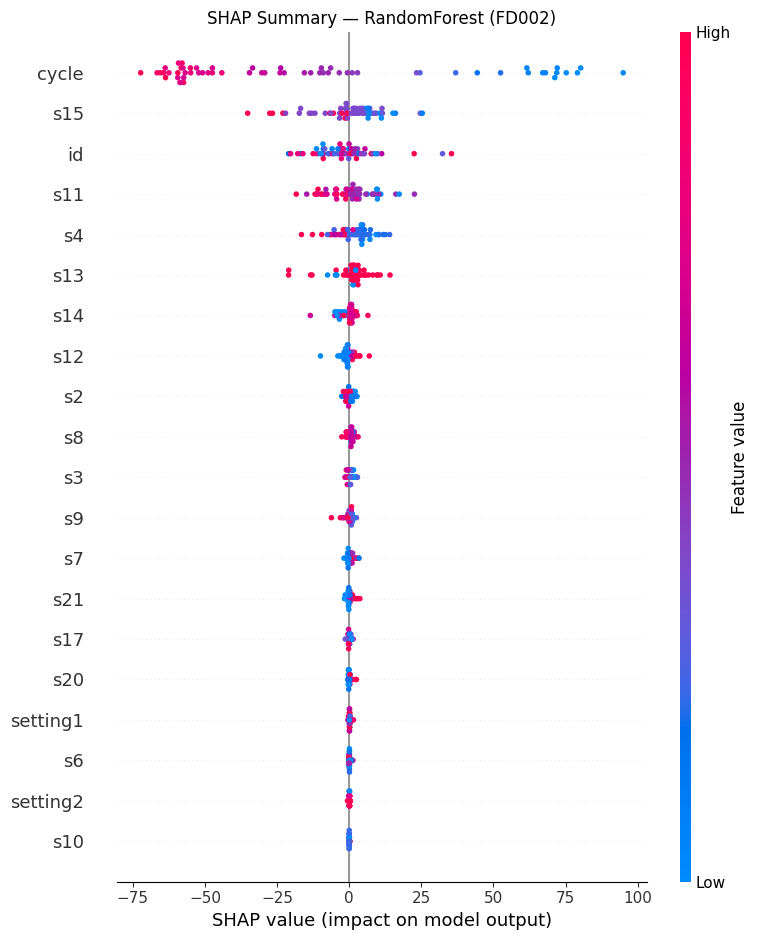

  0%|          | 0/60 [00:00<?, ?it/s]

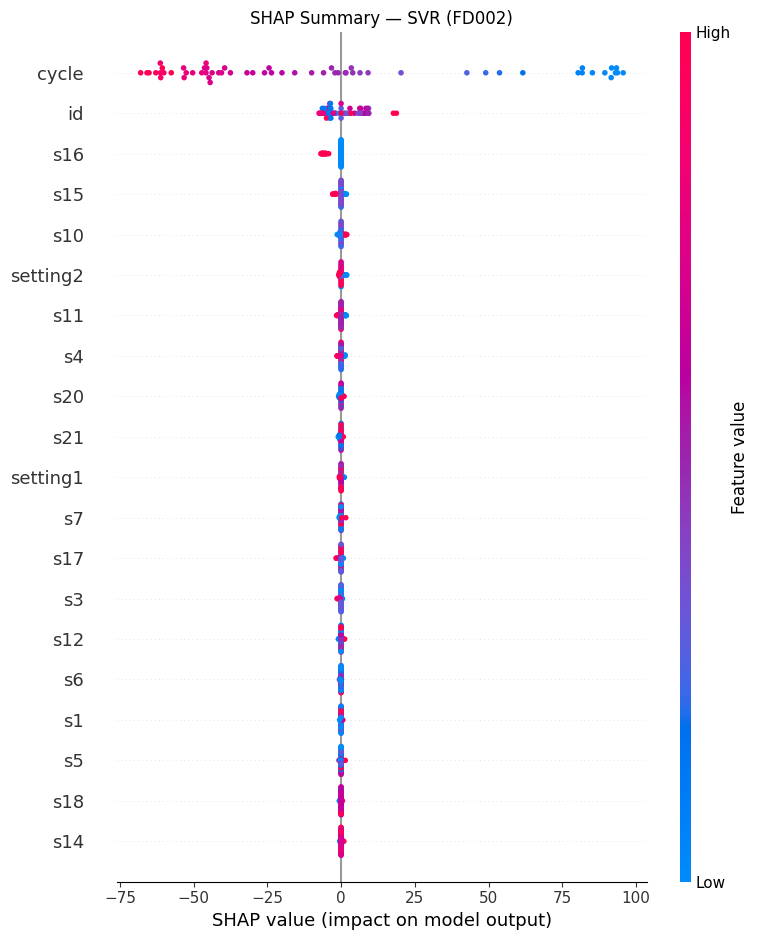

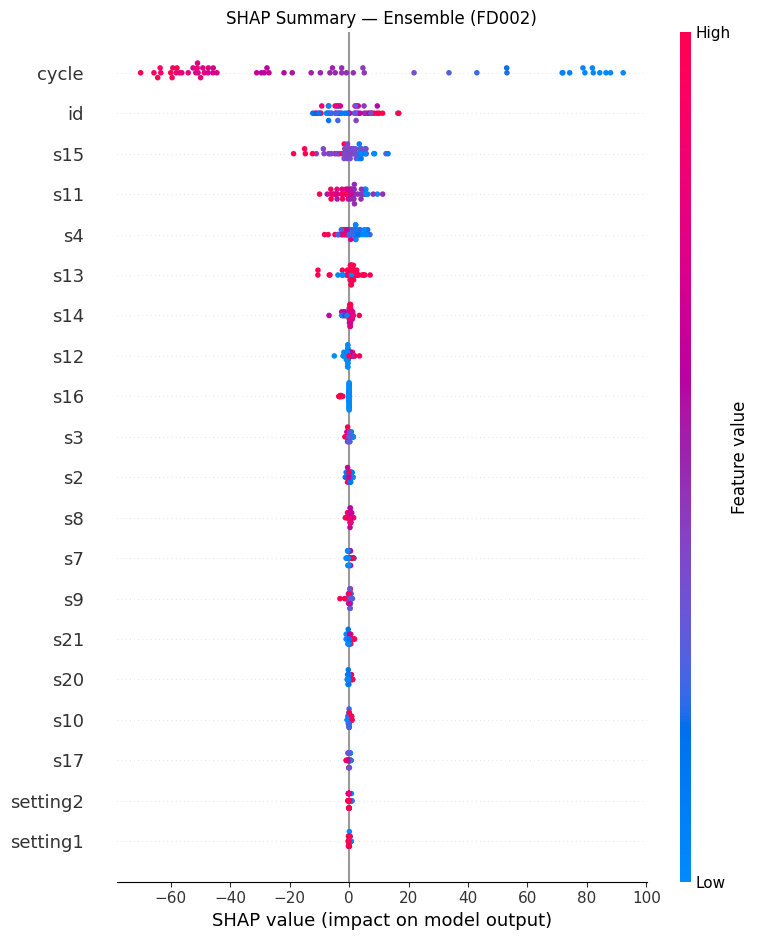

  0%|          | 0/1 [00:00<?, ?it/s]

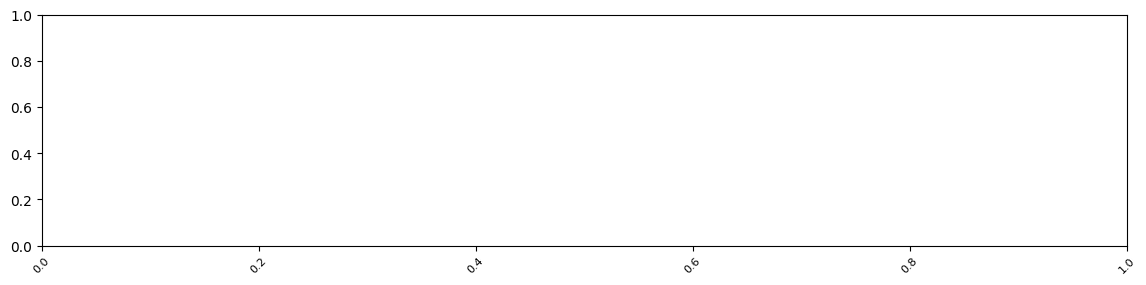

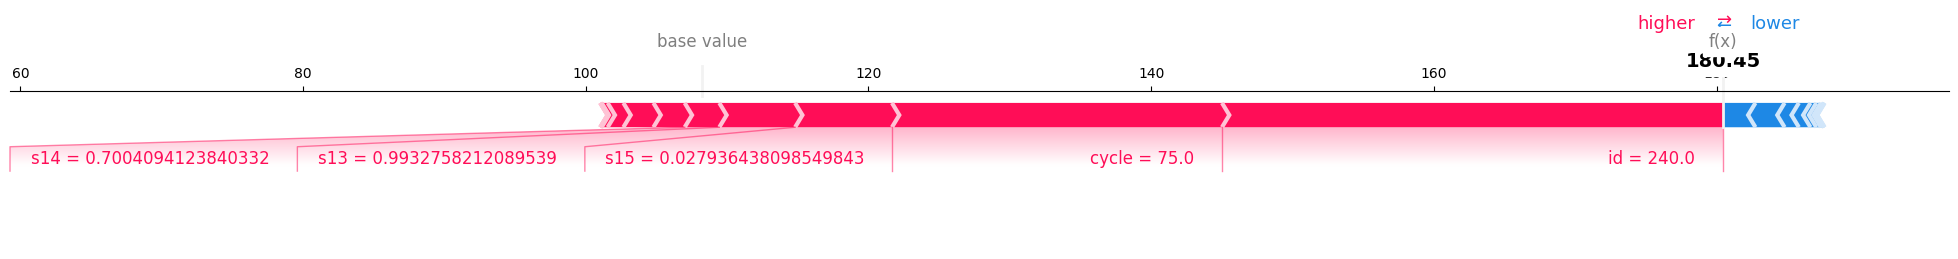

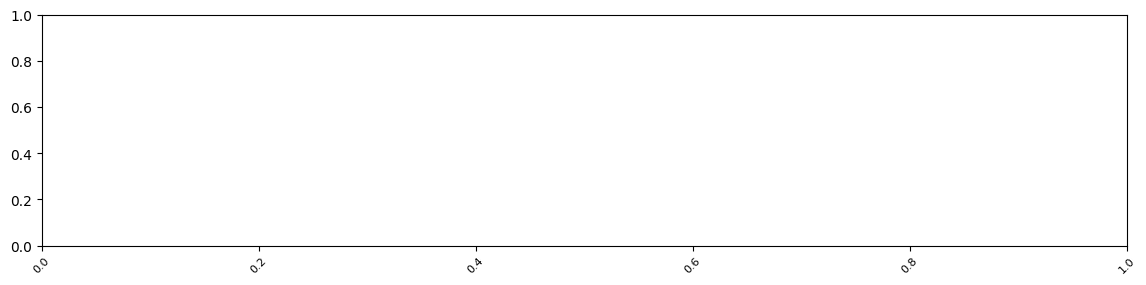

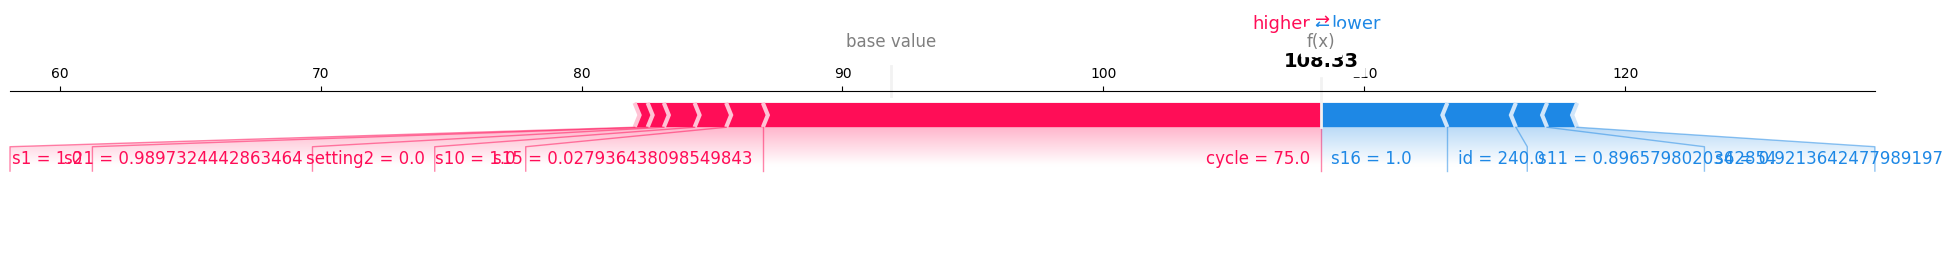

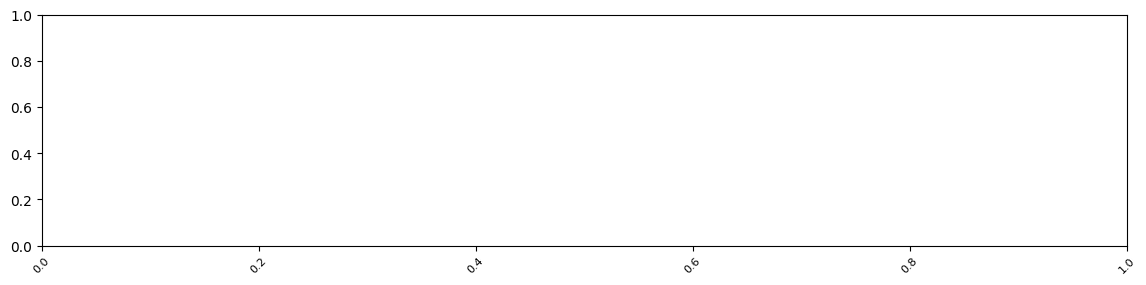

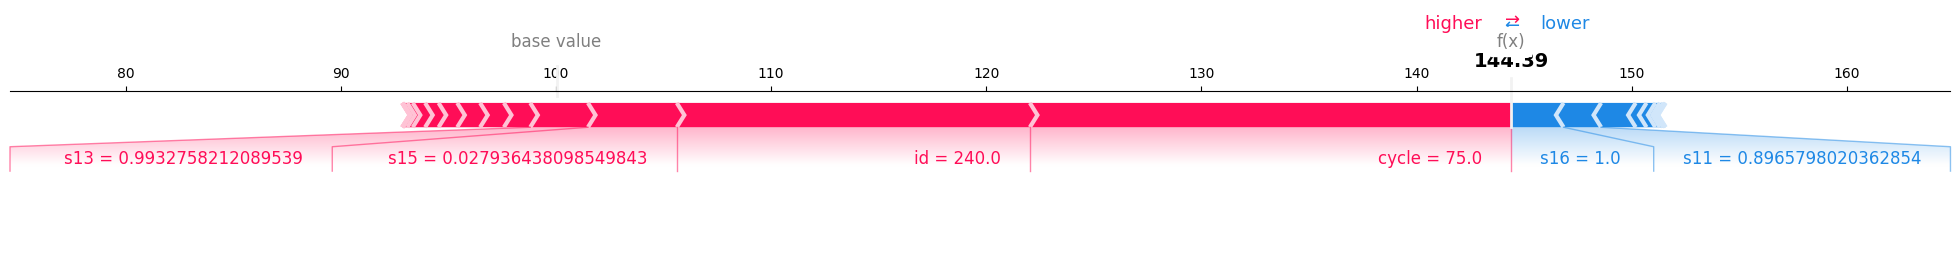

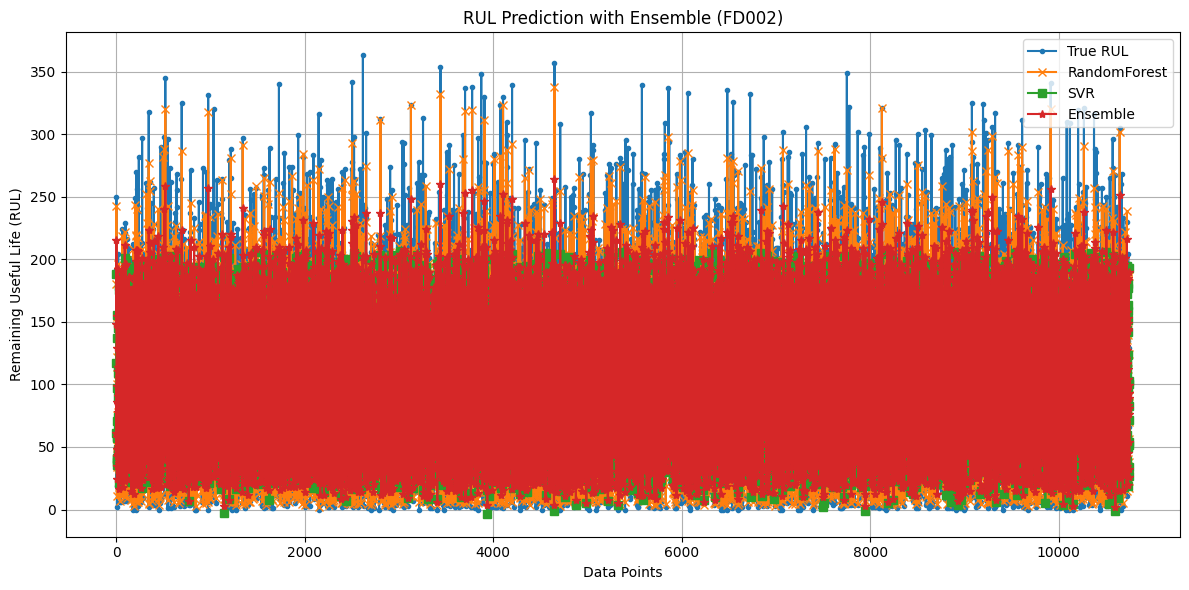



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (RandomForest) ---
Fold1: R2=0.5759, RMSE=45.3198, MAE=32.2687, PHM08_sum=67004994.4655, PHM08_avg=6230.1250
Fold2: R2=0.5585, RMSE=46.0422, MAE=31.6374, PHM08_sum=4921364446.9065, PHM08_avg=457843.9340
Fold3: R2=0.6579, RMSE=40.3075, MAE=28.5998, PHM08_sum=11157678.0631, PHM08_avg=1037.6340
Fold4: R2=0.6396, RMSE=41.3702, MAE=30.6578, PHM08_sum=15154385.6698, PHM08_avg=1409.3170
Fold5: R2=0.6290, RMSE=42.1393, MAE=30.5183, PHM08_sum=13541703.2462, PHM08_avg=1259.8105
Overall: R2=0.6120, RMSE=43.0944, MAE=30.7364, PHM08_sum=5028223208.3511, PHM08_avg=93532.6775

--- GroupKFold (SVR) ---
Fold1: R2=0.6604, RMSE=40.5587, MAE=28.8094, PHM08_sum=53827570.4454, PHM08_avg=5004.8880
Fold2: R2=0.7063, RMSE=37.5518, MAE=26.8045, PHM08_sum=10870575.7727, PHM08_avg

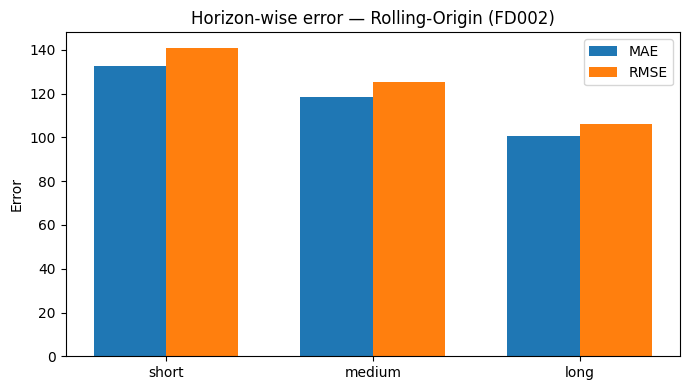

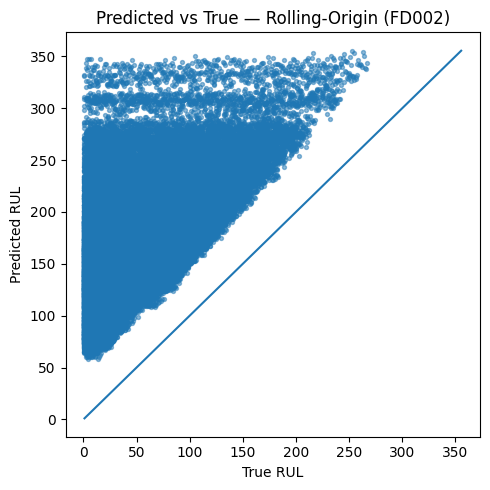


[PER-ENGINE MAE] (Top 10 worst engines)
112    180.567940
88     173.836567
85     173.337424
255    169.845148
118    165.335103
31     164.556447
158    152.918031
135    150.876287
260    149.926897
156    149.323955
dtype: float64


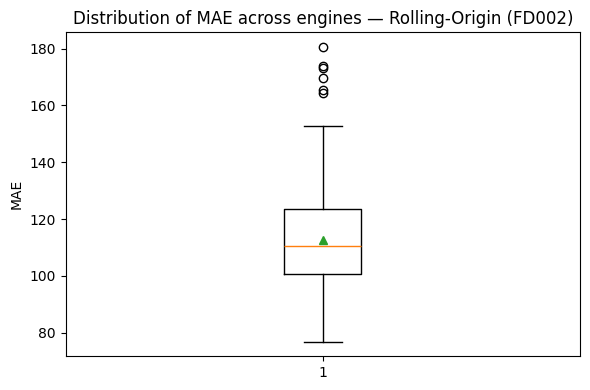

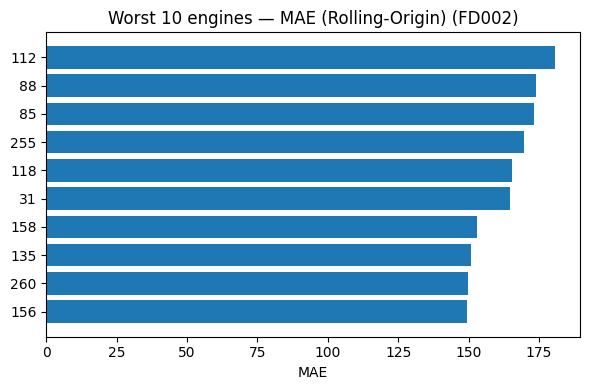


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -8.1613
    RMSE: 125.8262
     MAE: 118.2719
 sMAPE_%: 114.9532

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6124 ± 0.0397
Without id/cycle : R²=0.5950 ± 0.0283


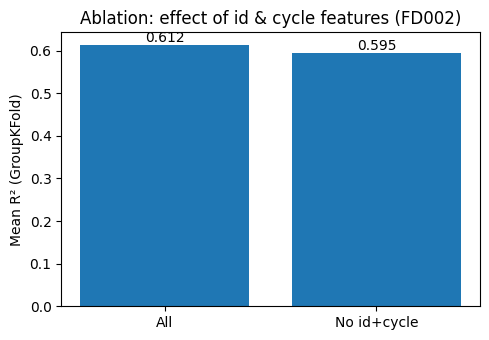


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 53759
Train (80%)   : 43007  → ratio=0.8000
Test  (20%)   : 10752  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 2915.05 seconds
CPU% at start        : 4.0%   (~0.10 GHz)
CPU% at end          : 26.1%   (~0.68 GHz)
Memory at start      : 1078.16 MB
Memory at end        : 1249.15 MB   (Δ 171.00 MB)


In [4]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD002"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "rfsvr"

# Fixed model hyperparameters (as requested)
RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    random_state=None,
    n_jobs=-1,
)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (RF + SVR)
# ============================================
rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_rf + 0.5 * y_svr

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_rf  = print_block_metrics("RandomForest", y_val, y_rf)
m_svr = print_block_metrics("SVR",          y_val, y_svr)
m_ens = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_rf, m_svr, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations
# RF: TreeExplainer; SVR: KernelExplainer 
# ============================================

X_tr32 = X_train.astype(np.float32)
X_val32 = X_val.astype(np.float32)

eval_size = min(60, X_val32.shape[0])
X_shap_small = X_val32.iloc[:eval_size]

# RandomForest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_vals_rf = explainer_rf.shap_values(X_shap_small)
shap.summary_plot(shap_vals_rf, X_shap_small, show=False)
plt.title(f"SHAP Summary — RandomForest ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_RF_{DATASET_NAME}.png")
plt.show()

# SVR SHAP (KernelExplainer)
bg_k = 15
X_bg = shap.kmeans(X_tr32, bg_k)
svr_explainer = shap.KernelExplainer(svr_model.predict, X_bg, link="identity")
shap_vals_svr = svr_explainer.shap_values(X_shap_small, nsamples=80)
shap.summary_plot(shap_vals_svr, X_shap_small, show=False)
plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average of contributions)
rf_arr = np.asarray(shap_vals_rf if not isinstance(shap_vals_rf, list) else shap_vals_rf[0])
svr_arr = np.asarray(shap_vals_svr)
min_n = min(rf_arr.shape[0], svr_arr.shape[0])
ens_arr = (rf_arr[:min_n] + svr_arr[:min_n]) / 2.0
shap.summary_plot(ens_arr, X_shap_small.iloc[:min_n], show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap_small.iloc[[0]]
rf_sv_row = explainer_rf.shap_values(row)
if isinstance(rf_sv_row, list):
    rf_sv_row = rf_sv_row[0]
rf_sv_row = np.asarray(rf_sv_row)[0]
rf_expected = explainer_rf.expected_value
if isinstance(rf_expected, (list, np.ndarray)):
    rf_expected = float(np.asarray(rf_expected).mean())

svr_sv_row = svr_explainer.shap_values(row, nsamples=160)[0]
svr_expected = float(np.mean(svr_model.predict(X_bg.data)))

ens_sv_row = (rf_sv_row + svr_sv_row) / 2.0
ens_expected = (rf_expected + svr_expected) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(rf_expected, rf_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_RF_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(svr_expected, svr_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(ens_expected, ens_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",  marker='x')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",      marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),  # harmless for RF; ensures identical pipeline to SVR
    ("model", RandomForestRegressor(**RF_PARAMS))
])
pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_rf,  name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, pipe_svr, name="SVR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RandomForest (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RandomForest (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



RandomForest Performance:
  R^2 Score:           0.9694
  Mean Squared Error:  299.9339
  Mean Absolute Error: 10.9675
  PHM08 Score (sum):   3025538.7089
  PHM08 Score (avg):   611.9617

SVR Performance:
  R^2 Score:           0.4152
  Mean Squared Error:  5731.3352
  Mean Absolute Error: 48.3547
  PHM08 Score (sum):   295709229539.8616
  PHM08 Score (avg):   59811737.3665

Ensemble Performance:
  R^2 Score:           0.8208
  Mean Squared Error:  1756.5442
  Mean Absolute Error: 28.2972
  PHM08 Score (sum):   21532357.1797
  PHM08 Score (avg):   4355.2502


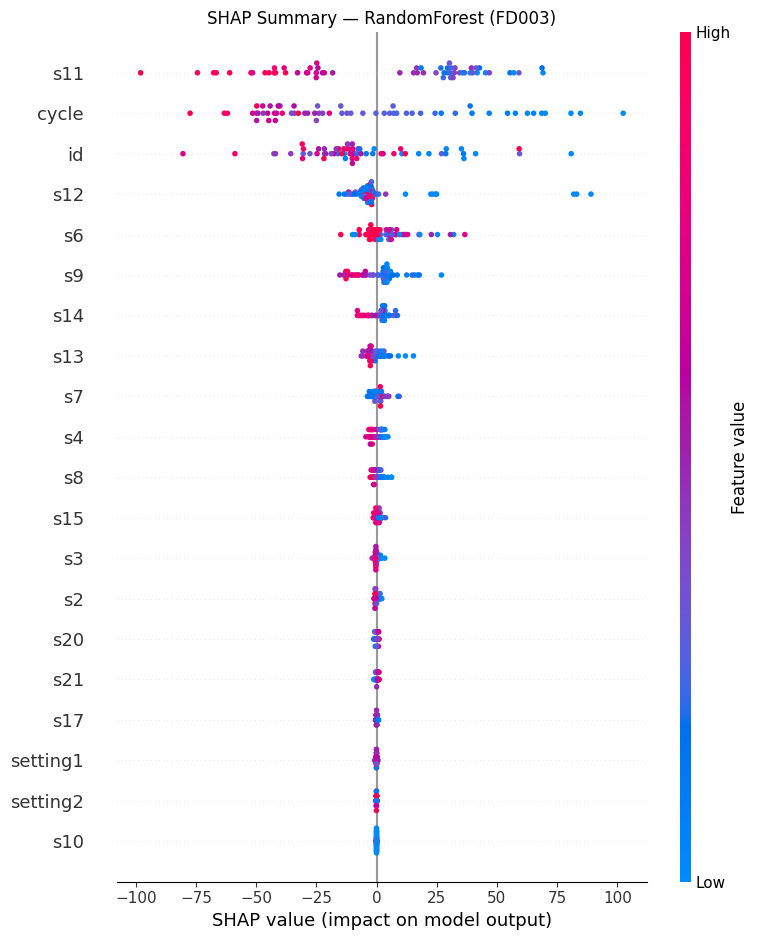

  0%|          | 0/60 [00:00<?, ?it/s]

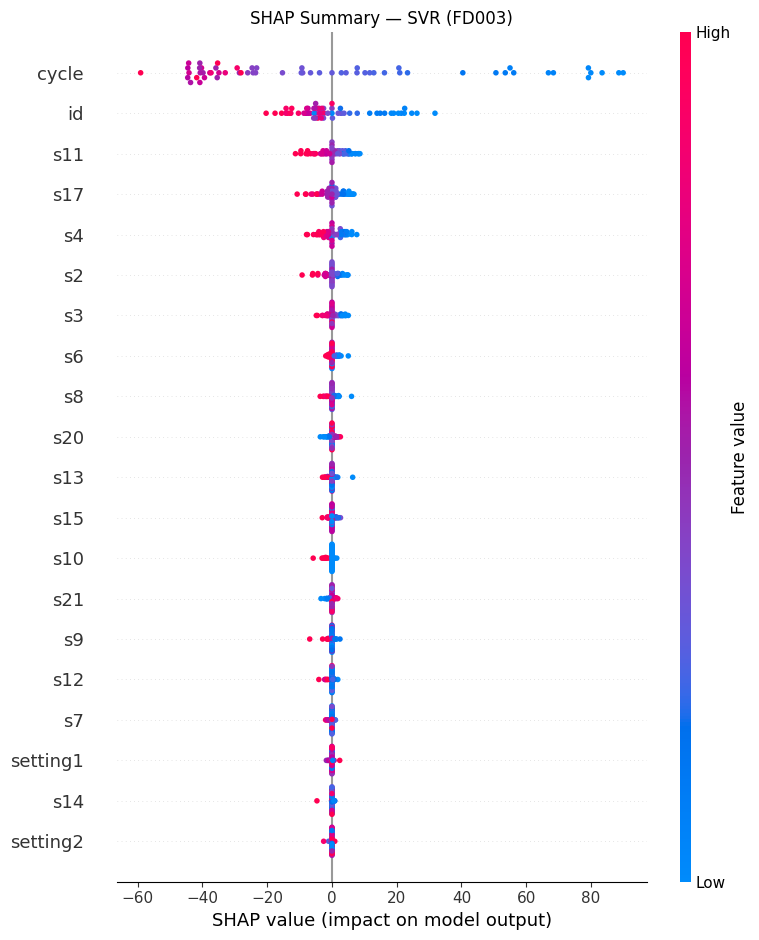

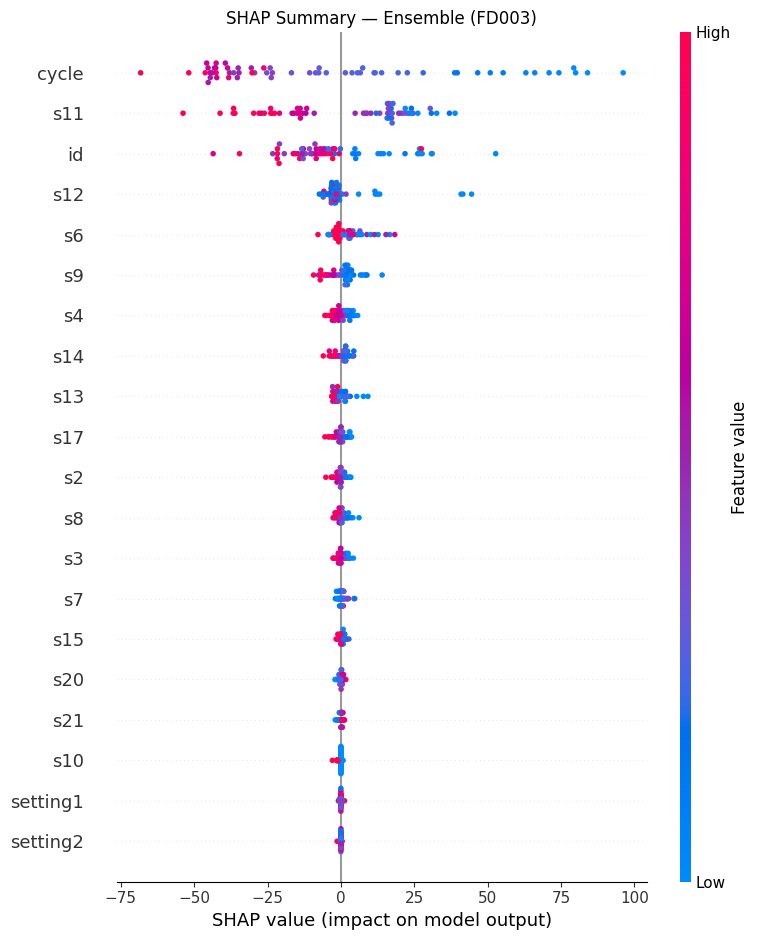

  0%|          | 0/1 [00:00<?, ?it/s]

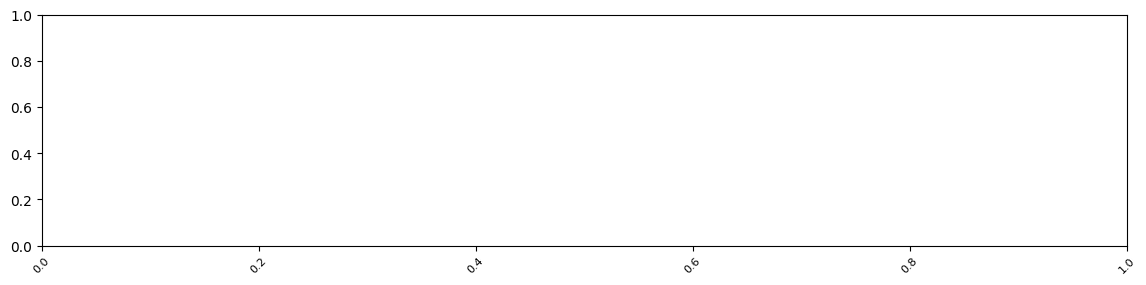

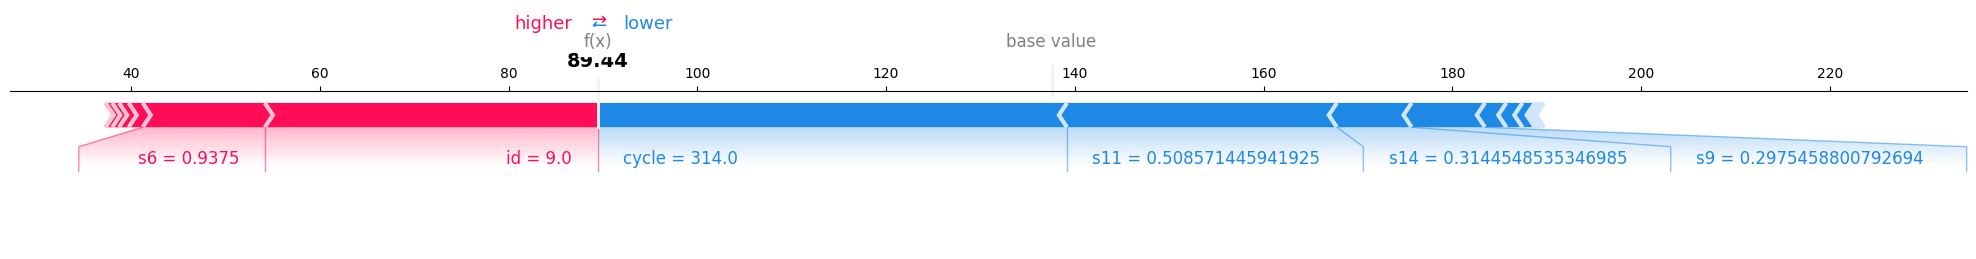

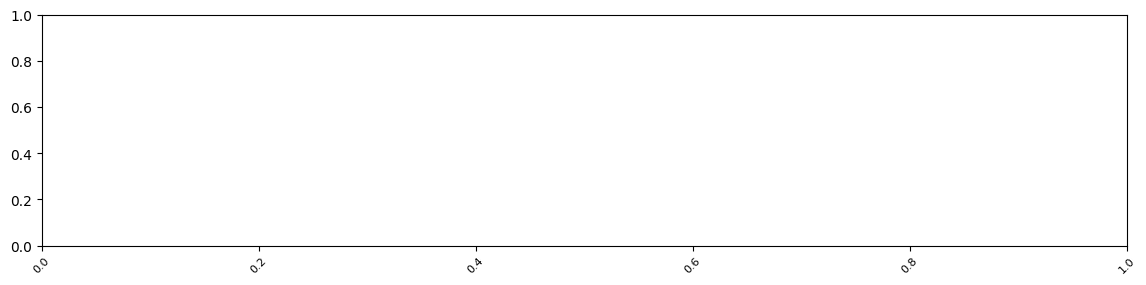

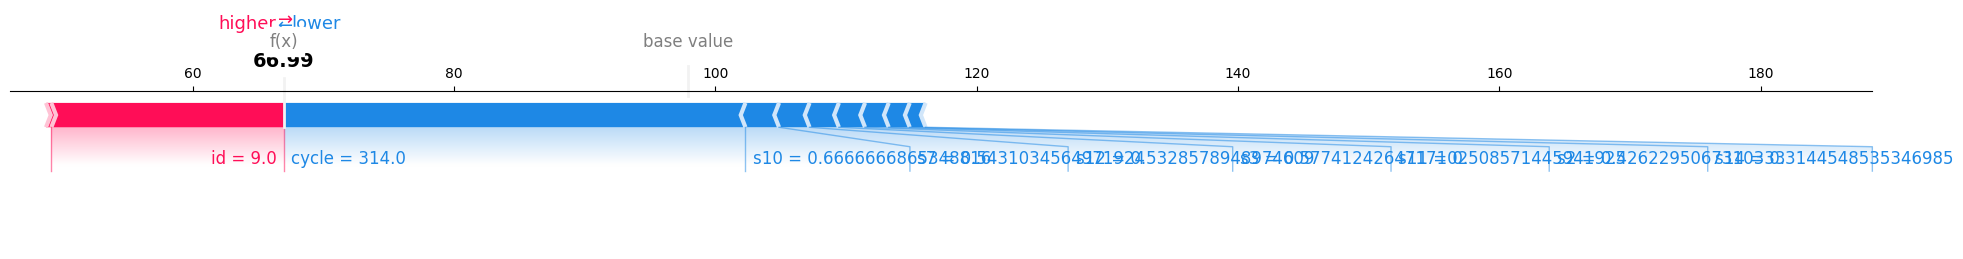

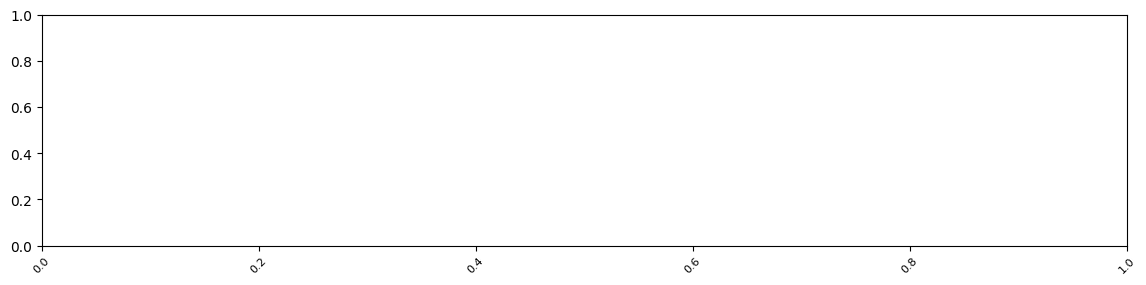

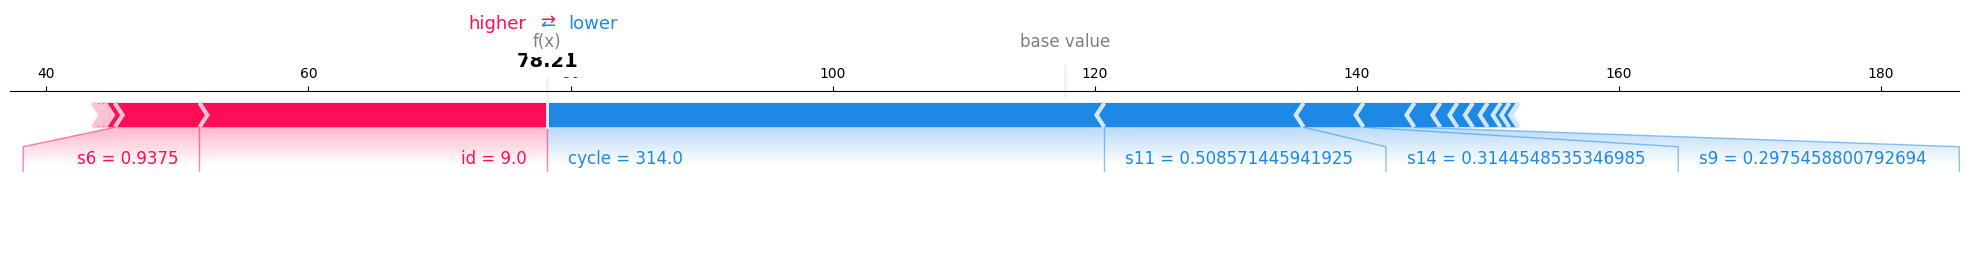

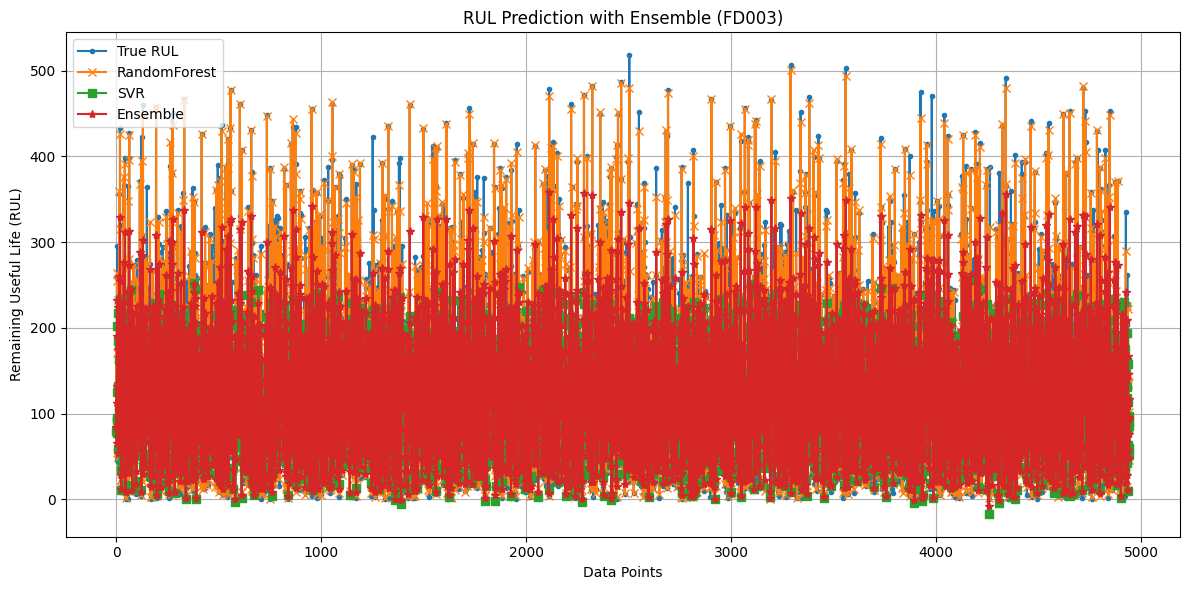



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (RandomForest) ---
Fold1: R2=0.2394, RMSE=88.3542, MAE=53.9393, PHM08_sum=10749275536370.1836, PHM08_avg=2175086106.1049
Fold2: R2=0.5938, RMSE=62.8750, MAE=41.8285, PHM08_sum=24671137937.9755, PHM08_avg=4988099.0574
Fold3: R2=0.3612, RMSE=78.6058, MAE=50.7635, PHM08_sum=112599941362194.4844, PHM08_avg=22765859555.6398
Fold4: R2=0.2496, RMSE=85.0191, MAE=52.6979, PHM08_sum=668221994285.6212, PHM08_avg=135267610.1793
Fold5: R2=0.4664, RMSE=71.3843, MAE=46.5699, PHM08_sum=4272697489800.7778, PHM08_avg=863869286.2517
Overall: R2=0.3806, RMSE=77.7942, MAE=49.1582, PHM08_sum=128314807520589.0469, PHM08_avg=5190728459.5708

--- GroupKFold (SVR) ---
Fold1: R2=0.5541, RMSE=67.6505, MAE=46.4484, PHM08_sum=764741126246.3462, PHM08_avg=154743246.9135
Fold2: R2=0.7

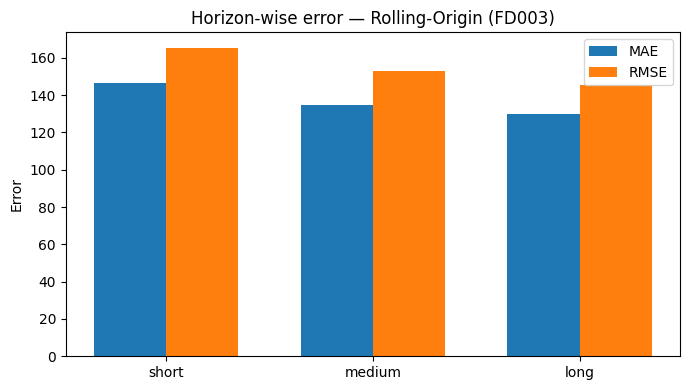

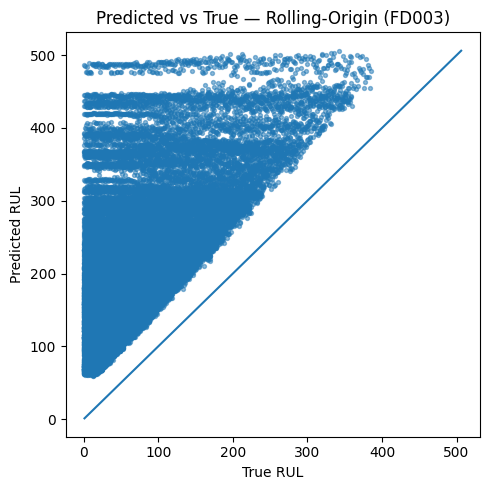


[PER-ENGINE MAE] (Top 10 worst engines)
55    224.516914
24    213.352175
96    208.191996
10    205.459860
34    201.907433
18    201.416324
7     187.865914
9     187.846910
71    178.871124
94    170.876386
dtype: float64


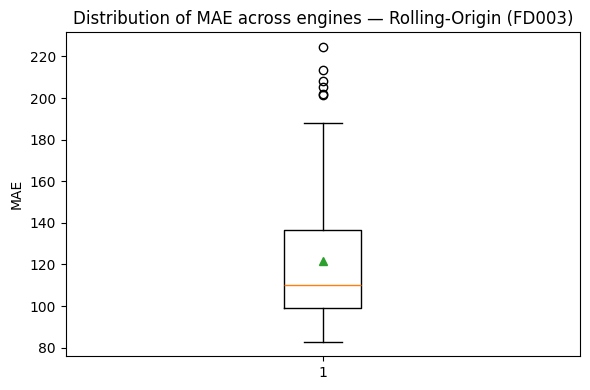

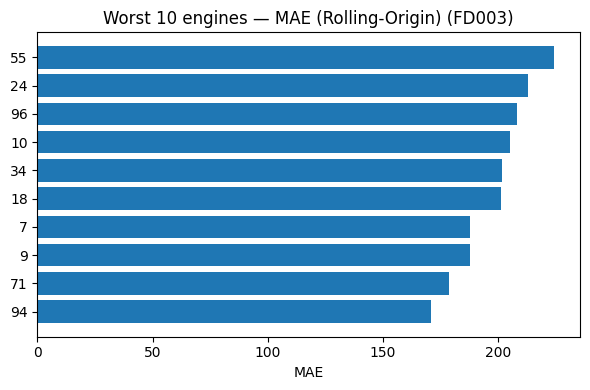


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -4.9422
    RMSE: 153.2693
     MAE: 135.9704
 sMAPE_%: 107.7524

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.3790 ± 0.1347
Without id/cycle : R²=0.5653 ± 0.0925


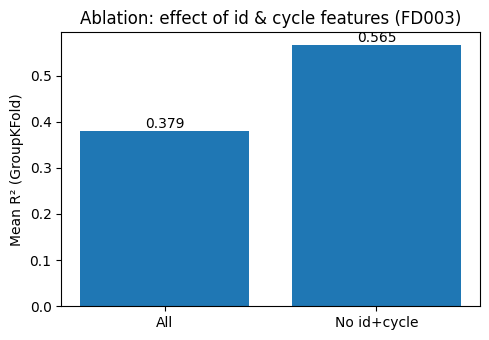


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 24720
Train (80%)   : 19776  → ratio=0.8000
Test  (20%)   : 4944  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1065.64 seconds
CPU% at start        : 4.7%   (~0.12 GHz)
CPU% at end          : 33.1%   (~0.86 GHz)
Memory at start      : 1249.41 MB
Memory at end        : 1122.48 MB   (Δ -126.93 MB)


In [5]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD003"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "rfsvr"

# Fixed model hyperparameters (as requested)
RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    random_state=None,
    n_jobs=-1,
)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (RF + SVR)
# ============================================
rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_rf + 0.5 * y_svr

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_rf  = print_block_metrics("RandomForest", y_val, y_rf)
m_svr = print_block_metrics("SVR",          y_val, y_svr)
m_ens = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_rf, m_svr, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations
# RF: TreeExplainer; SVR: KernelExplainer 
# ============================================

X_tr32 = X_train.astype(np.float32)
X_val32 = X_val.astype(np.float32)

eval_size = min(60, X_val32.shape[0])
X_shap_small = X_val32.iloc[:eval_size]

# RandomForest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_vals_rf = explainer_rf.shap_values(X_shap_small)
shap.summary_plot(shap_vals_rf, X_shap_small, show=False)
plt.title(f"SHAP Summary — RandomForest ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_RF_{DATASET_NAME}.png")
plt.show()

# SVR SHAP (KernelExplainer)
bg_k = 15
X_bg = shap.kmeans(X_tr32, bg_k)
svr_explainer = shap.KernelExplainer(svr_model.predict, X_bg, link="identity")
shap_vals_svr = svr_explainer.shap_values(X_shap_small, nsamples=80)
shap.summary_plot(shap_vals_svr, X_shap_small, show=False)
plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average of contributions)
rf_arr = np.asarray(shap_vals_rf if not isinstance(shap_vals_rf, list) else shap_vals_rf[0])
svr_arr = np.asarray(shap_vals_svr)
min_n = min(rf_arr.shape[0], svr_arr.shape[0])
ens_arr = (rf_arr[:min_n] + svr_arr[:min_n]) / 2.0
shap.summary_plot(ens_arr, X_shap_small.iloc[:min_n], show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap_small.iloc[[0]]
rf_sv_row = explainer_rf.shap_values(row)
if isinstance(rf_sv_row, list):
    rf_sv_row = rf_sv_row[0]
rf_sv_row = np.asarray(rf_sv_row)[0]
rf_expected = explainer_rf.expected_value
if isinstance(rf_expected, (list, np.ndarray)):
    rf_expected = float(np.asarray(rf_expected).mean())

svr_sv_row = svr_explainer.shap_values(row, nsamples=160)[0]
svr_expected = float(np.mean(svr_model.predict(X_bg.data)))

ens_sv_row = (rf_sv_row + svr_sv_row) / 2.0
ens_expected = (rf_expected + svr_expected) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(rf_expected, rf_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_RF_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(svr_expected, svr_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(ens_expected, ens_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",  marker='x')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",      marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),  # harmless for RF; ensures identical pipeline to SVR
    ("model", RandomForestRegressor(**RF_PARAMS))
])
pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_rf,  name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, pipe_svr, name="SVR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RandomForest (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RandomForest (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



RandomForest Performance:
  R^2 Score:           0.7781
  Mean Squared Error:  1784.0836
  Mean Absolute Error: 30.6769
  PHM08 Score (sum):   18041169658.1615
  PHM08 Score (avg):   1472748.5435

SVR Performance:
  R^2 Score:           0.4152
  Mean Squared Error:  4702.1223
  Mean Absolute Error: 51.9143
  PHM08 Score (sum):   616829278504.8711
  PHM08 Score (avg):   50353410.4902

Ensemble Performance:
  R^2 Score:           0.6717
  Mean Squared Error:  2639.8247
  Mean Absolute Error: 38.5399
  PHM08 Score (sum):   47658624768.5572
  PHM08 Score (avg):   3890499.9811


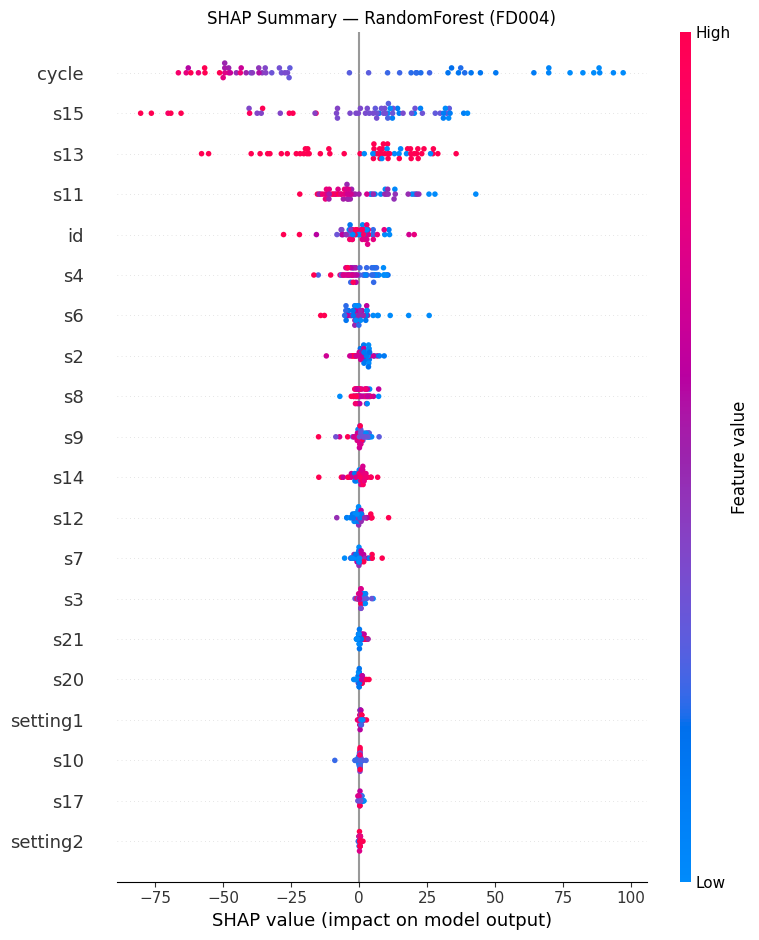

  0%|          | 0/60 [00:00<?, ?it/s]

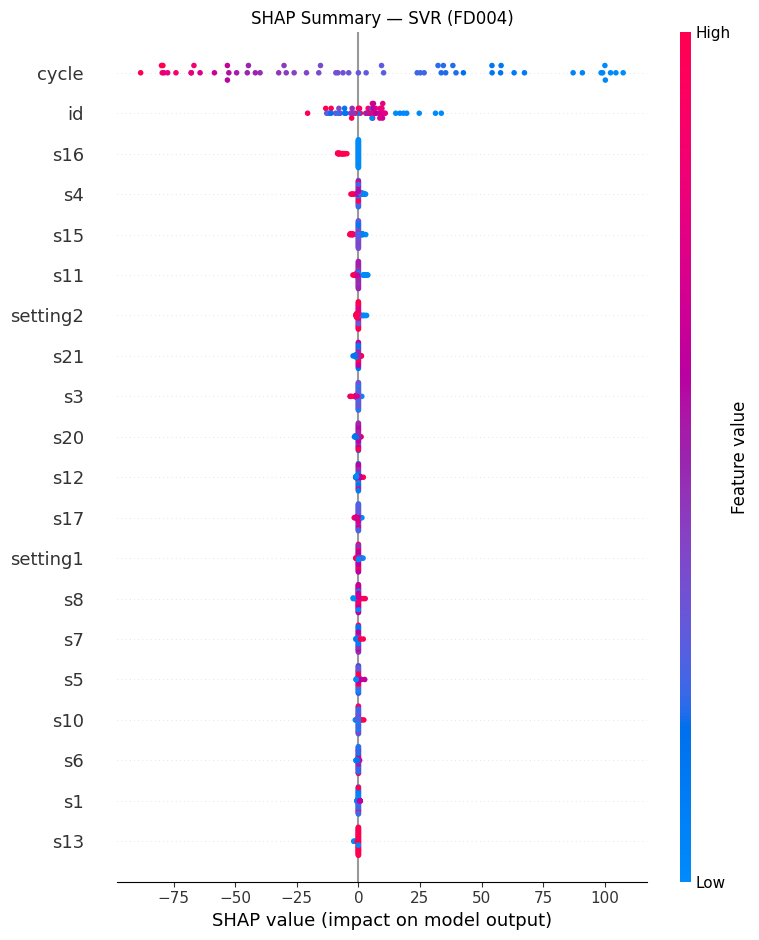

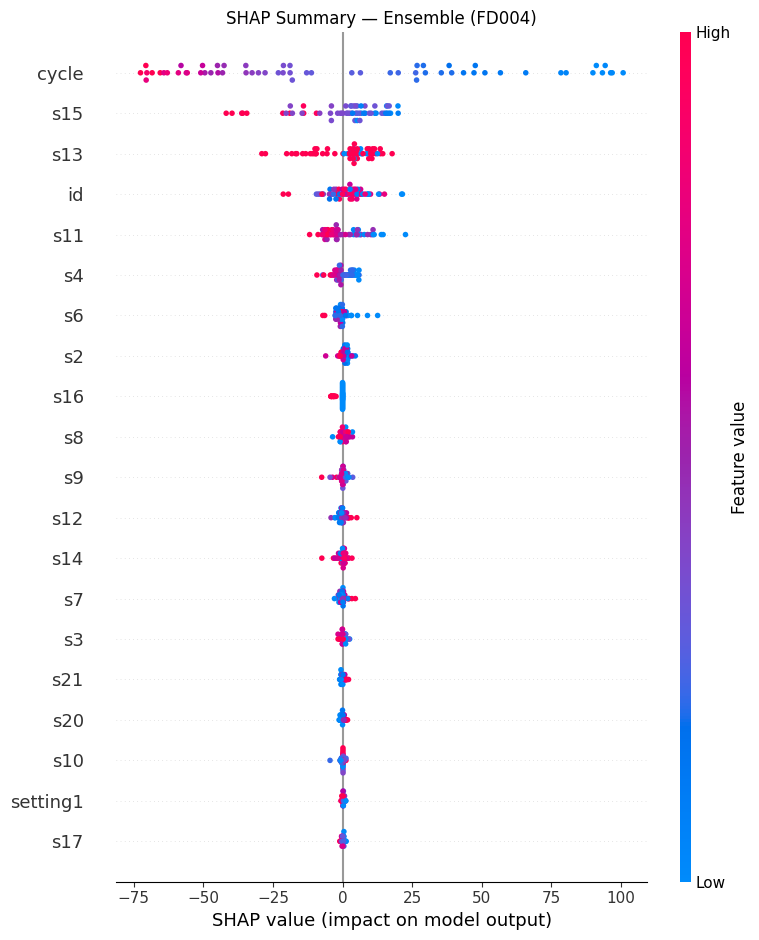

  0%|          | 0/1 [00:00<?, ?it/s]

/home/testai/vdi-forecast-env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


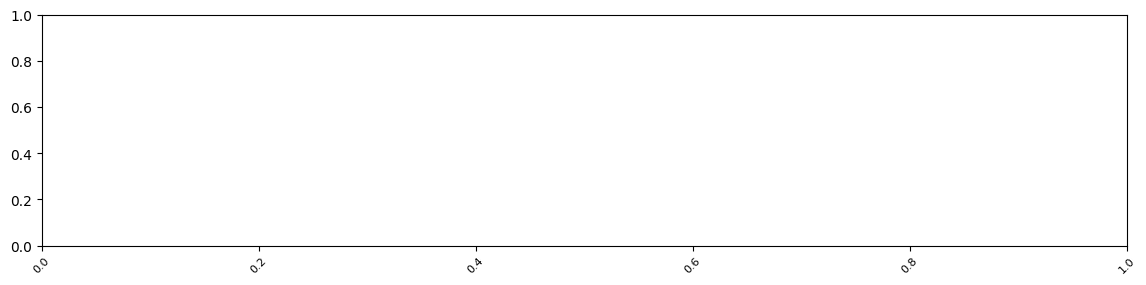

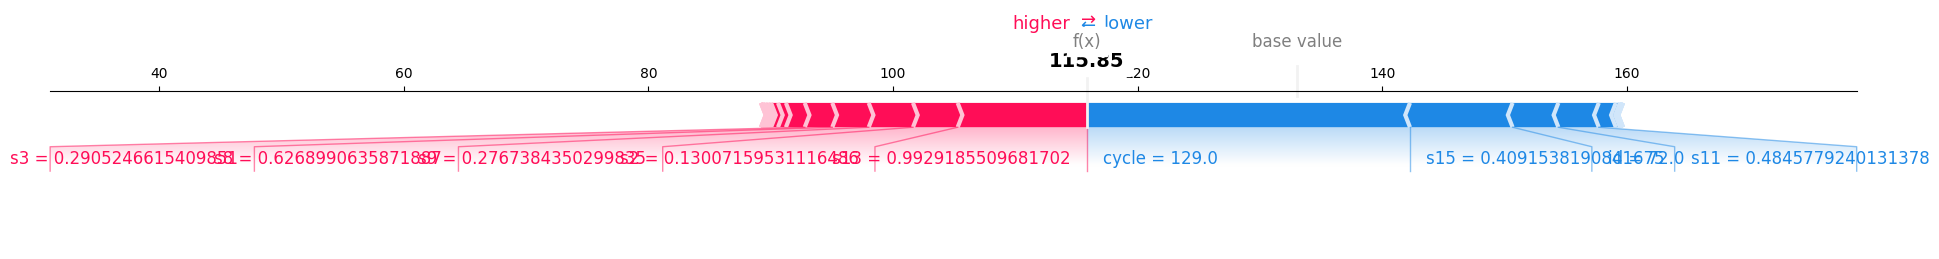

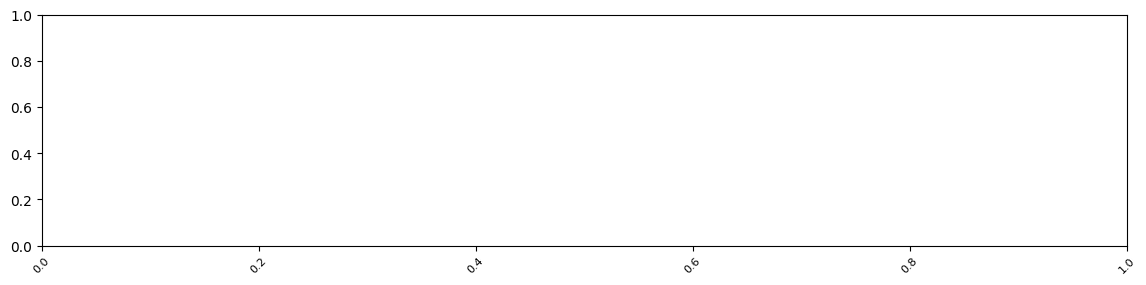

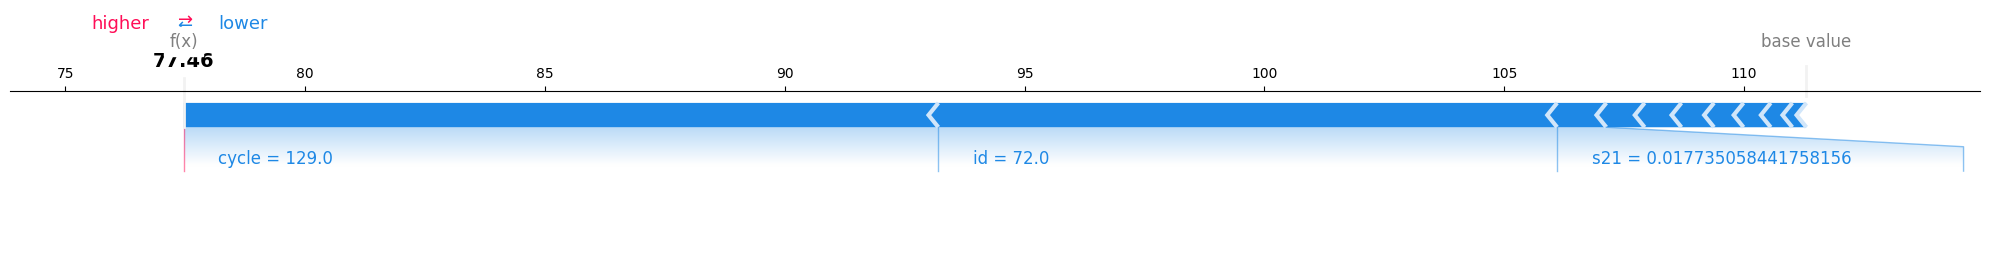

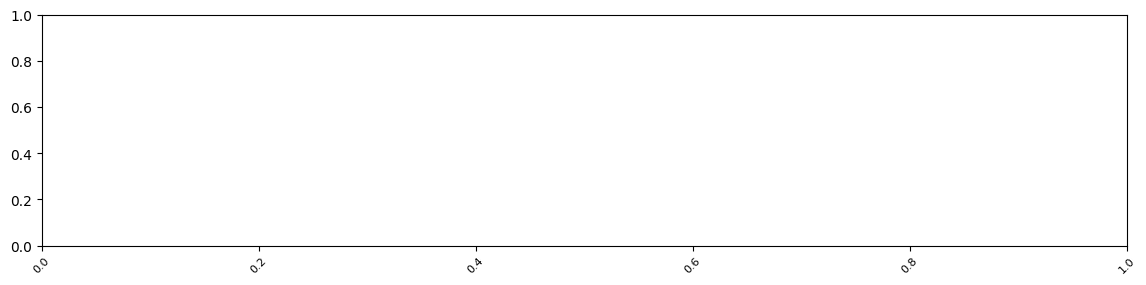

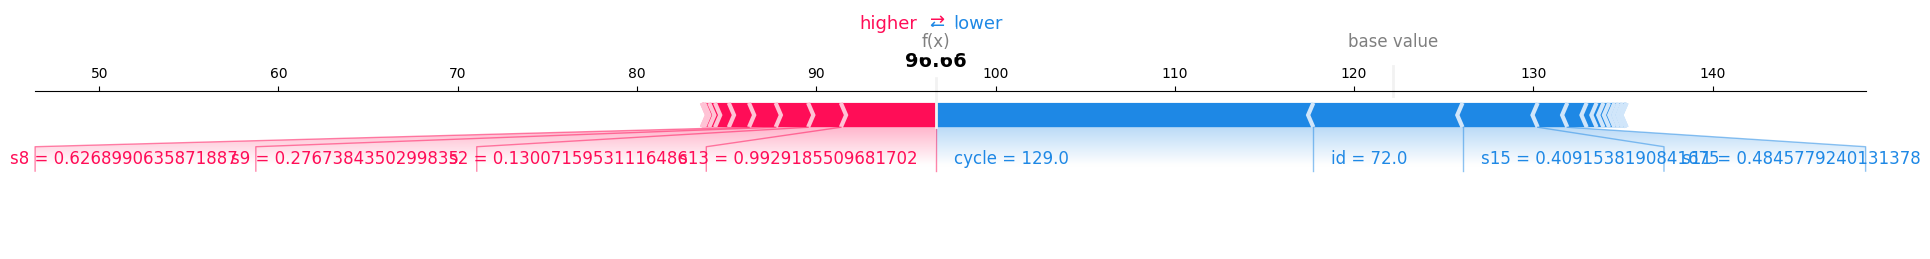

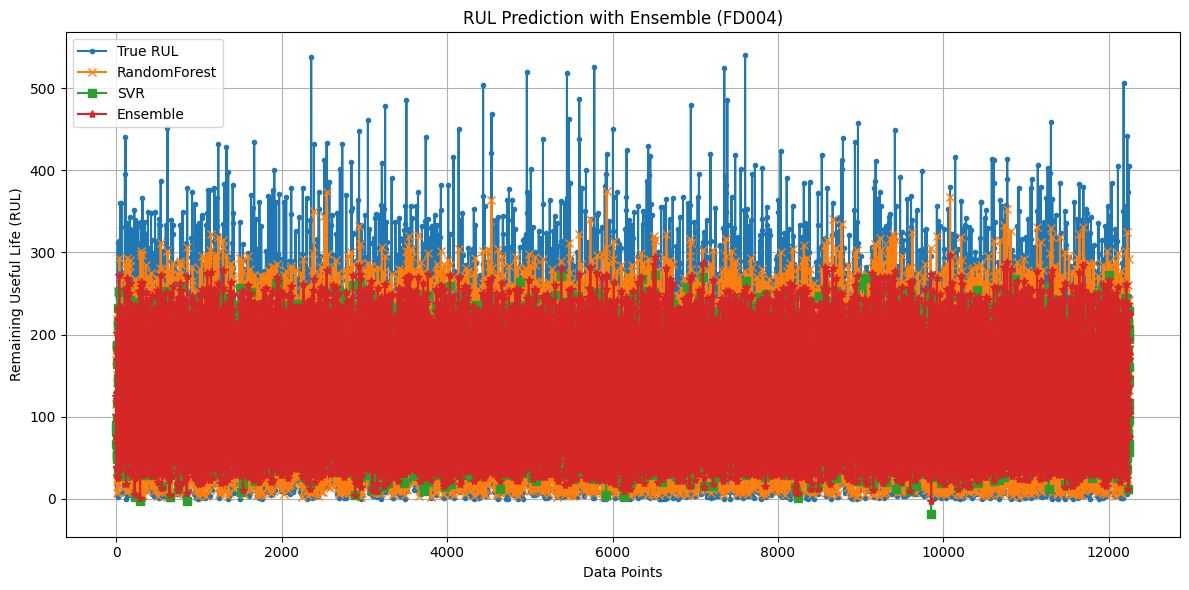



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (RandomForest) ---
Fold1: R2=0.5042, RMSE=65.3189, MAE=45.0299, PHM08_sum=2790040352955.4819, PHM08_avg=227201983.1397
Fold2: R2=0.6774, RMSE=51.0743, MAE=35.0881, PHM08_sum=5182511359.8909, PHM08_avg=426684.6171
Fold3: R2=0.6465, RMSE=52.8508, MAE=38.7501, PHM08_sum=345964099.6582, PHM08_avg=28189.0410
Fold4: R2=0.6682, RMSE=51.0615, MAE=37.3677, PHM08_sum=7515406997.1863, PHM08_avg=612302.9980
Fold5: R2=0.6663, RMSE=51.1878, MAE=36.6834, PHM08_sum=238918353.1108, PHM08_avg=19462.2314
Overall: R2=0.6303, RMSE=54.5899, MAE=38.5917, PHM08_sum=2803323153765.3281, PHM08_avg=45769288.5397

--- GroupKFold (SVR) ---
Fold1: R2=0.5750, RMSE=60.4700, MAE=41.5285, PHM08_sum=949529087882.3086, PHM08_avg=77323215.6256
Fold2: R2=0.6890, RMSE=50.1451, MAE=35.5941, PH

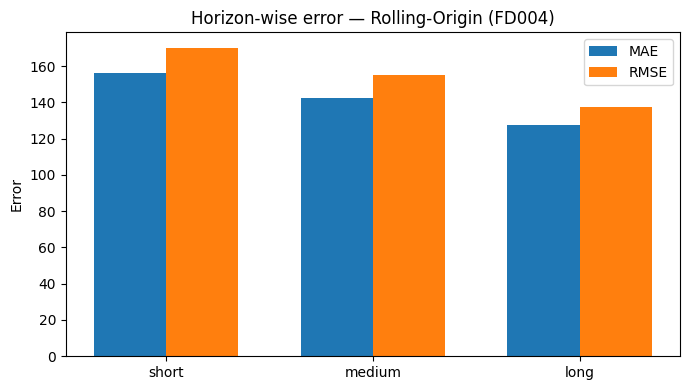

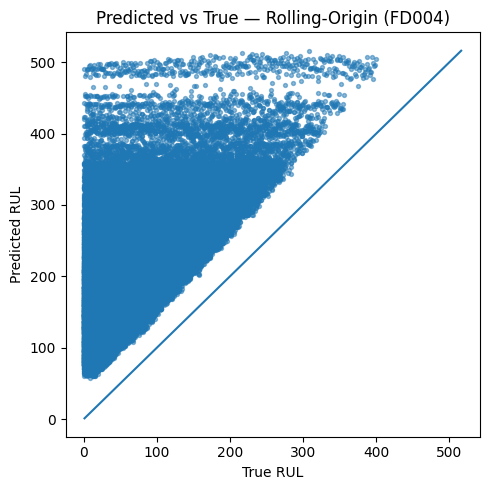


[PER-ENGINE MAE] (Top 10 worst engines)
118    254.732455
133    227.929780
173    213.694250
49     210.336344
179    210.168296
225    203.511170
171    194.234354
158    192.268172
88     188.893051
131    188.247876
dtype: float64


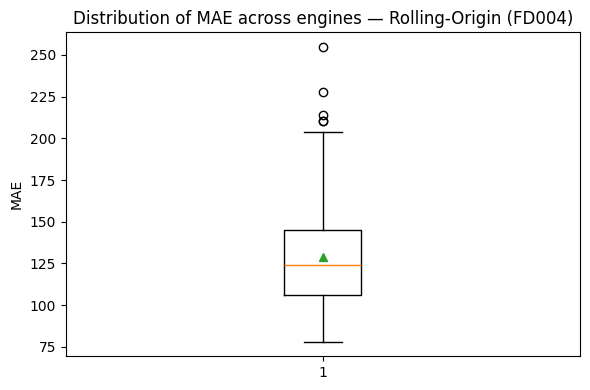

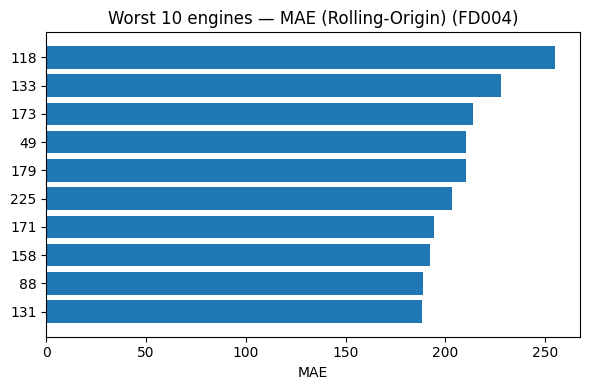


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -6.4021
    RMSE: 152.9309
     MAE: 140.1507
 sMAPE_%: 111.1306

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6304 ± 0.0656
Without id/cycle : R²=0.5937 ± 0.0378


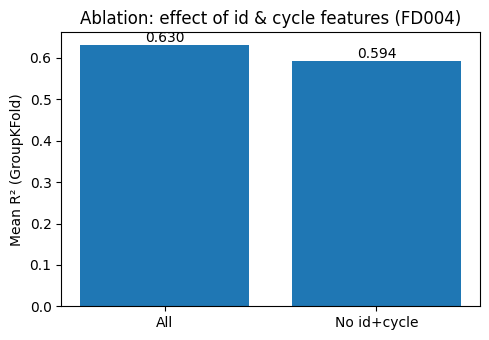


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 2999.98 seconds
CPU% at start        : 17.6%   (~0.46 GHz)
CPU% at end          : 23.6%   (~0.61 GHz)
Memory at start      : 282.16 MB
Memory at end        : 1151.52 MB   (Δ 869.36 MB)


In [1]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "rfsvr"

# Fixed model hyperparameters (as requested)
RF_PARAMS = dict(
    n_estimators=100,
    max_depth=14,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    random_state=None,
    n_jobs=-1,
)
SVM_PARAMS = dict(
    C=500,
    epsilon=0.5,
    gamma='scale',
    kernel='rbf'
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================
# Model training (RF + SVR)
# ============================================
rf_model = RandomForestRegressor(**RF_PARAMS)
rf_model.fit(X_train, y_train)
y_rf = rf_model.predict(X_val)

svr_model = SVR(**SVM_PARAMS)
svr_model.fit(X_train, y_train)
y_svr = svr_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_rf + 0.5 * y_svr

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_rf  = print_block_metrics("RandomForest", y_val, y_rf)
m_svr = print_block_metrics("SVR",          y_val, y_svr)
m_ens = print_block_metrics("Ensemble",     y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_rf, m_svr, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations
# RF: TreeExplainer; SVR: KernelExplainer 
# ============================================

X_tr32 = X_train.astype(np.float32)
X_val32 = X_val.astype(np.float32)

eval_size = min(60, X_val32.shape[0])
X_shap_small = X_val32.iloc[:eval_size]

# RandomForest SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_vals_rf = explainer_rf.shap_values(X_shap_small)
shap.summary_plot(shap_vals_rf, X_shap_small, show=False)
plt.title(f"SHAP Summary — RandomForest ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_RF_{DATASET_NAME}.png")
plt.show()

# SVR SHAP (KernelExplainer)
bg_k = 15
X_bg = shap.kmeans(X_tr32, bg_k)
svr_explainer = shap.KernelExplainer(svr_model.predict, X_bg, link="identity")
shap_vals_svr = svr_explainer.shap_values(X_shap_small, nsamples=80)
shap.summary_plot(shap_vals_svr, X_shap_small, show=False)
plt.title(f"SHAP Summary — SVR ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_SVR_{DATASET_NAME}.png")
plt.show()

# Ensemble SHAP (average of contributions)
rf_arr = np.asarray(shap_vals_rf if not isinstance(shap_vals_rf, list) else shap_vals_rf[0])
svr_arr = np.asarray(shap_vals_svr)
min_n = min(rf_arr.shape[0], svr_arr.shape[0])
ens_arr = (rf_arr[:min_n] + svr_arr[:min_n]) / 2.0
shap.summary_plot(ens_arr, X_shap_small.iloc[:min_n], show=False)
plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
plt.tight_layout()
save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
plt.show()

# Single-row force plots
row = X_shap_small.iloc[[0]]
rf_sv_row = explainer_rf.shap_values(row)
if isinstance(rf_sv_row, list):
    rf_sv_row = rf_sv_row[0]
rf_sv_row = np.asarray(rf_sv_row)[0]
rf_expected = explainer_rf.expected_value
if isinstance(rf_expected, (list, np.ndarray)):
    rf_expected = float(np.asarray(rf_expected).mean())

svr_sv_row = svr_explainer.shap_values(row, nsamples=160)[0]
svr_expected = float(np.mean(svr_model.predict(X_bg.data)))

ens_sv_row = (rf_sv_row + svr_sv_row) / 2.0
ens_expected = (rf_expected + svr_expected) / 2.0

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(rf_expected, rf_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_RF_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(svr_expected, svr_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_SVR_Single_{DATASET_NAME}.png")
plt.show()

fig, ax = plt.subplots(figsize=(14, 3))
_ = shap.force_plot(ens_expected, ens_sv_row, row.iloc[0].values,
                    feature_names=row.columns.tolist(), matplotlib=True, show=False)
ax.tick_params(axis='x', rotation=45, labelsize=8)
plt.tight_layout()
save_png(f"Local_SHAP_force_Ensemble_Single_{DATASET_NAME}.png")
plt.show()

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_rf)),       y_rf,           label="RandomForest",  marker='x')
plt.plot(range(len(y_svr)),      y_svr,          label="SVR",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",      marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),  # harmless for RF; ensures identical pipeline to SVR
    ("model", RandomForestRegressor(**RF_PARAMS))
])
pipe_svr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", SVR(**SVM_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_rf,  name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, pipe_svr, name="SVR")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_rf():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])

def build_pipe_svr():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", SVR(**SVM_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, name="RandomForest"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_svr, name="SVR"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", RandomForestRegressor(**RF_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_rf, name="RandomForest")
_ = cv_eval_pipeline(X, y, groups, build_pipe_rf(), name="RandomForest (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=0,  name=f"Rolling-Origin RandomForest (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf,
    embargo_val=10, name=f"Rolling-Origin RandomForest (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_rf
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_rf)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_rf)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")
